In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from collections import defaultdict

C:\soft\anaconda\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["TF_FORCE_GPU_ALLOW_CROWTH"] = "true"

## 数据清洗

In [7]:
# 读取文本数据
file_path = 'dataset/goods_zh.txt'
df = pd.read_csv(file_path)  
df.head()

,才用就发现相机打开迟钝，半天反应不过来，有时候还会卡出去，他们又不给解决方案。,Unnamed: 1,0
0,还没穿二天就起毛了,NaN,0
1,坑呢！能教我怎样将双卡和内存卡一起装进去吗？如果不能，说什么支持双卡和SD?-,NaN,0
2,诺基亚手机做工质量太差，后壳太垃圾没用几天就掉漆了，为毛要用金属材质，为啥不用陶瓷材质后壳呀...,NaN,0
3,整体的感觉还是不错的，，，，，,NaN,1
4,非常不满意京东的售后服务，买之前联系客服说由于公司新开，公司增值税发票的开票信息还没出来，要...,NaN,0


**通过初步观察可以发现：**

1. 数据集本身没有标题
2. Unnamed列可能代表着发出此评价的用户名，数据内容是NaN，说明这是多余的
3. 最后一列是label：0代表着负面，1代表着正面

接下来要进行数据集的清洗

In [8]:
#删除多余列
df = df.dropna(axis=1, how='all')  # 删除所有值为 NaN 的列

df.columns = ['Review', 'Label']  # 为已有的 DataFrame 设置新的列名

In [9]:
df.head()


,Review,Label
0,还没穿二天就起毛了,0
1,坑呢！能教我怎样将双卡和内存卡一起装进去吗？如果不能，说什么支持双卡和SD?-,0
2,诺基亚手机做工质量太差，后壳太垃圾没用几天就掉漆了，为毛要用金属材质，为啥不用陶瓷材质后壳呀...,0
3,整体的感觉还是不错的，，，，，,1
4,非常不满意京东的售后服务，买之前联系客服说由于公司新开，公司增值税发票的开票信息还没出来，要...,0


In [10]:
# 检查是否有缺失值
print(df.isnull().sum())

Review    1
Label     0
dtype: int64


In [11]:
# 删除含有缺失值的行
df = df.dropna(subset=['Review'])

# 重置索引
df = df.reset_index(drop=True)

# 再次检查是否还有缺失值
print("清理后缺失值数量:", df['Review'].isnull().sum())

清理后缺失值数量: 0


In [12]:
#随机检查一些评论和标签，确保标签符合实际语义
df.sample(10)

,Review,Label
83494,物流速度太慢了。。，手机一般般,0
98568,收到的包装就是这样的，特别简陋，差评,0
44113,手机是还可以 但是打开盒子里面连入门指南都没给我装，有这么忙吗,0
29022,IFINITY应用多开的功能没有了，纯属上当受骗啊！不如360N5!,0
38052,不错,1
24358,要求退货，未用一个月，主板就坏了！???,1
63601,很满意,1
26181,第一次在京东买东西，买了自己一直很想买的笔记本电脑！嘻嘻&hellip;&hellip;快递...,1
83920,质量真的是太差了！！刚买的新手机，换了新卡刚用上就总是通话中自动挂断，刚接通几秒钟就自动挂断...,0
79919,好评给手机，，差评给京东的，一直推卸责任，4月12日抢购，19号到货，中间咨询一直推卸责任，...,0


In [13]:
#打印列名
print(df.columns)

# 检查数据集大小
print(df.shape)

Index(['Review', 'Label'], dtype='object')
(101056, 2)


Label
0    50556
1    50500
Name: count, dtype: int64


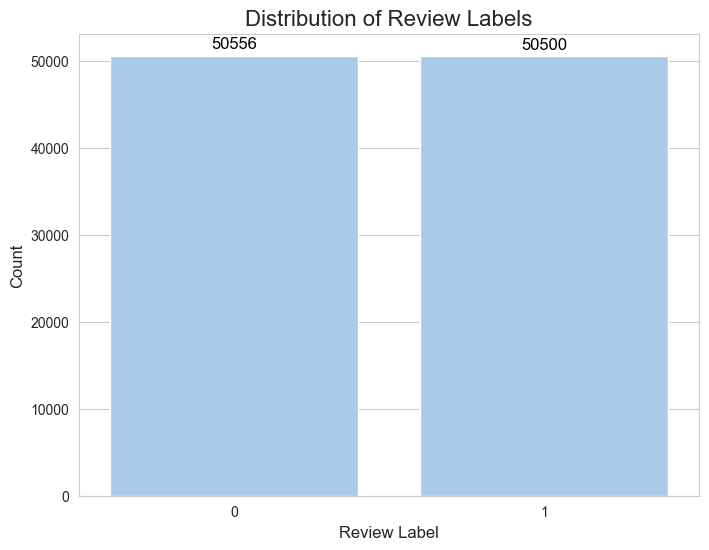

In [14]:
# 检查标签分布
print(df['Label'].value_counts())

# 画出标签分布的柱状图
plt.figure(figsize=(8, 6)) 
sns.set_style('whitegrid') 
sns.set_palette('pastel')  
ax = sns.countplot(x='Label', data=df)

# 在柱子上显示计数
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# 添加标题和标签
plt.xlabel('Review Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Review Labels', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

至此，得到了一个较为干净整洁的数据集。数据分布也很均匀。可以继续数据处理了。

## 数据处理

### 1. 分词器选择

In [15]:
# 加载中文 BERT 的分词器
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese' 
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
tokenizer

BertTokenizer(name_or_path='bert-base-chinese', vocab_size=21128, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

### 2. 分词与 ID 映射

In [17]:
# 示例中文句子
sample_txt = "我非常喜欢这款商品，质量很好，值得购买。"

# 分词
tokens = tokenizer.tokenize(sample_txt)

# 将分词后的 tokens 转为 ID
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"文本为: {sample_txt}")
print(f"分词的结果为: {tokens}")
print(f"词对应的唯一ID: {token_ids}")

文本为: 我非常喜欢这款商品，质量很好，值得购买。
分词的结果为: ['我', '非', '常', '喜', '欢', '这', '款', '商', '品', '，', '质', '量', '很', '好', '，', '值', '得', '购', '买', '。']
词对应的唯一ID: [2769, 7478, 2382, 1599, 3614, 6821, 3621, 1555, 1501, 8024, 6574, 7030, 2523, 1962, 8024, 966, 2533, 6579, 743, 511]


### 3. 添加特殊标记并完成编码
在使用 BERT 时，输入需要包括特殊标记（如 [CLS] 和 [SEP]），可以通过分词器的 encode 方法自动完成。

In [18]:
# 对文本进行编码，包含 [CLS] 和 [SEP]
encoded = tokenizer.encode_plus(
    sample_txt,
    max_length=128,               # 最大长度
    add_special_tokens=True,      # [CLS]和[SEP]
    return_token_type_ids=True,
    padding='max_length',         # 补齐到最大长度
    return_attention_mask=True,
    truncation=True,              # 截断超出部分
    return_tensors='pt'           # 返回 PyTorch 的 Tensor
)

encoded.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [19]:
encoded

{'input_ids': tensor([[ 101, 2769, 7478, 2382, 1599, 3614, 6821, 3621, 1555, 1501, 8024, 6574,
         7030, 2523, 1962, 8024,  966, 2533, 6579,  743,  511,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0,

In [20]:
print(len(encoded['input_ids'][0]))
print(len(encoded['attention_mask'][0]))

128
128


由此可见，input_ids与attention_mask都是具有相同的长度（128）的张量

现在将ids字符反转，打印一下每个字符是什么

In [21]:
tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])

['[CLS]',
 '我',
 '非',
 '常',
 '喜',
 '欢',
 '这',
 '款',
 '商',
 '品',
 '，',
 '质',
 '量',
 '很',
 '好',
 '，',
 '值',
 '得',
 '购',
 '买',
 '。',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',


#### 检查文本的最大长度

In [22]:
token_lens = []

for txt in df.Review:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


C:\Users\Sucre\AppData\Local\Temp\ipykernel_12584\2583240476.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

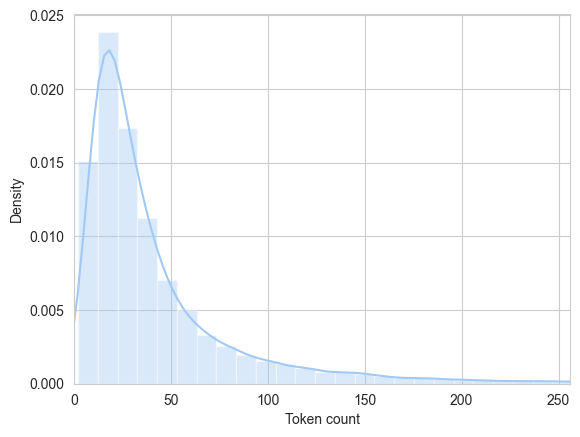

In [23]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

可以看到大多数文本的ids长度在200以内，我们设置最大长度为250

In [24]:
MAX_LEN = 250

### 4. 批量处理文本数据

In [25]:
# 设置随机种子
RANDOM_SEED = 1221

# 数据集拆分为训练集、验证集和测试集
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)  # 先划分出 10% 的测试集
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)  # 将测试集再划分为验证集和测试集

# 查看各数据集大小
print("训练集大小:", df_train.shape)
print("验证集大小:", df_val.shape)
print("测试集大小:", df_test.shape)


训练集大小: (90950, 2)
验证集大小: (5053, 2)
测试集大小: (5053, 2)


### 5. 数据集和数据加载器

定义这个 SentimentDataset 类的目的是 将你的数据集（包含 Review 和 Label 列）转换为适合 PyTorch 模型训练的数据格式。简单来说，它是一个专门为 PyTorch 设计的数据加载类，可以在模型训练时高效地处理文本和标签。

在深度学习项目中，模型通常需要输入张量（Tensor），而你的数据集是一个 DataFrame 或其他表格格式的数据，因此需要一个工具将其转化为适合 PyTorch 的输入格式。SentimentDataset 就是为此目的设计的。

In [26]:
class SentimentDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        # 使用分词器对评论进行编码
        encoded = tokenizer.encode_plus(
            sample_txt,
            max_length=128,               # 最大长度
            add_special_tokens=True,      # [CLS]和[SEP]
            return_token_type_ids=True,
            padding='max_length',         # 补齐到最大长度
            return_attention_mask=True,
            truncation=True,              # 截断超出部分
            return_tensors='pt'           # 返回 PyTorch 的 Tensor
)

        return {
            'review_text': review,
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [27]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = SentimentDataset(
        reviews=df.Review.to_numpy(),
        labels=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [28]:
BATCH_SIZE = 16

# 创建数据加载器
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
#检查第一批数据
data = next(iter(train_data_loader))
print("Input IDs shape:", data['input_ids'].shape)
print("Attention Mask shape:", data['attention_mask'].shape)
print("Labels shape:", data['label'].shape)

Input IDs shape: torch.Size([16, 128])
Attention Mask shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


## Sentiment Classification

In [30]:
# 加载预训练的 BERT 模型用于分类任务
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)

# 查看模型结构
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [31]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)  
        self.drop = nn.Dropout(p=0.3)  # Dropout 防止过拟合
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)  # 输出层

    def forward(self, input_ids, attention_mask):
        # 获取 BERT 的 pooled_output
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False  # 返回元组
        )
        output = self.drop(pooled_output)  # 加入 Dropout
        return self.out(output)  # 全连接层输出


In [32]:
# 类别数量 (根据你的数据集定义)
n_classes = 2 

# 实例化模型
model = SentimentClassifier(n_classes)

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [33]:
#准备输入数据
# 从 DataLoader 获取一批数据
data = next(iter(train_data_loader))  
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

# 检查输入数据形状
print("Input IDs shape:", input_ids.shape)  # (batch_size, seq_len)
print("Attention Mask shape:", attention_mask.shape)  # (batch_size, seq_len)


Input IDs shape: torch.Size([16, 128])
Attention Mask shape: torch.Size([16, 128])


In [34]:
# 通过 softmax 转换为概率分布
probabilities = F.softmax(outputs, dim=1)

print("Probabilities:", probabilities)  # 每个类别的概率

NameError: name 'outputs' is not defined

## 模型训练


In [35]:
EPOCHS = 1

# 定义损失函数和优化器
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)  # 调整学习率（根据需要）
loss_fn = nn.CrossEntropyLoss().to(device)

# 计算总训练步数
total_steps = len(train_data_loader) * EPOCHS

# 计算 warmup steps
warmup_steps = int(0.1 * total_steps)  # 设置 warmup 为总步数的 10%

# 定义学习率调度器
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,        # 预热步数
  num_training_steps=total_steps       # 总训练步数
)

C:\soft\anaconda\envs\llm\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
):
    model = model.train()  # 切换到训练模式
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["label"].to(device).long()  # 确保标签是整数类型

        # 模型前向传播
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # 获取预测结果
        _, preds = torch.max(outputs, dim=1)

        # 计算损失
        loss = loss_fn(outputs, targets)

        # 统计正确预测数量
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # 反向传播
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # 返回准确率和平均损失
    return correct_predictions.double() / n_examples, np.mean(losses)


In [42]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()  # 切换到评估模式
    losses = []
    correct_predictions = 0

    with torch.no_grad():  # 禁用梯度计算
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["label"].to(device).long()  # 确保标签是整数类型

            # 前向传播
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)  # 获取预测结果

            # 计算损失
            loss = loss_fn(outputs, targets)

            # 统计正确预测数量
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    # 返回准确率和平均损失
    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
import time
from collections import defaultdict
import torch

history = defaultdict(list)
best_accuracy = 0

# 定义总样本数
n_examples = len(df_train)

# 开始训练
model = model.train()  # 确保模型处于训练模式

print(f'Starting Training...')

batch_count = 0  # 用于统计批次数
total_correct_predictions = 0  # 全局正确预测数
total_loss = 0  # 全局累积损失

for d in train_data_loader:  # 遍历数据加载器的每个批次
    batch_count += 1
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["label"].to(device).long()

    # 前向传播
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    time.sleep(0.1)

    # 获取预测结果
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    # 统计当前批次的正确预测数和准确率
    correct_predictions = torch.sum(preds == targets).item()
    accuracy = correct_predictions / len(targets)  # 当前批次的准确率

    # 更新全局统计
    total_correct_predictions += correct_predictions  # 累积正确预测数
    total_loss += loss.item()  # 累积损失

    # 反向传播
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    # 控制打印频率，每 10 个批次打印一次
    if batch_count % 10 == 0:
        print(f"Batch {batch_count}/{len(train_data_loader)}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.4f}")

# 计算全局准确率和平均损失
overall_accuracy = total_correct_predictions / n_examples
average_loss = total_loss / len(train_data_loader)

# 打印全局统计结果
print(f"\nTraining Complete!")
print(f"Overall Training Accuracy: {overall_accuracy:.4f}")
print(f"Overall Training Loss: {average_loss:.4f}")

# 保存历史记录
history['train_loss'].append(average_loss)
history['train_acc'].append(overall_accuracy)


Starting Training...
Batch 10/5685: Loss = 0.6808, Accuracy = 0.5000
Batch 20/5685: Loss = 0.6968, Accuracy = 0.6250
Batch 30/5685: Loss = 0.7351, Accuracy = 0.5000
Batch 40/5685: Loss = 0.7934, Accuracy = 0.5625
Batch 50/5685: Loss = 0.6216, Accuracy = 0.6875


In [82]:
history

defaultdict(list,
            {'train_loss': [0.711976214637857],
             'train_acc': [0.5009455744914788]})

In [44]:
# 可视化训练损失和验证损失
def plot_training_history(history):
    """
    绘制训练和验证的损失及准确率曲线
    :param history: 字典形式的训练历史数据
    """
    # 创建一个 2x1 的子图布局
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # 绘制损失曲线
    ax1.plot(history['train_loss'], label='Train Loss', color='blue', marker='o')
    if 'val_loss' in history:
        ax1.plot(history['val_loss'], label='Validation Loss', color='orange', marker='o')
    ax1.set_title('Loss Over Batches/Epochs', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.5)

    # 绘制准确率曲线
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue', marker='o')
    if 'val_acc' in history:
        ax2.plot(history['val_acc'], label='Validation Accuracy', color='orange', marker='o')
    ax2.set_title('Accuracy Over Batches/Epochs', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(loc='lower right')
    ax2.grid(alpha=0.5)

    # 调整布局并显示图形
    plt.tight_layout()
    plt.show()
